# Business Questions. 
_We want answers!_ 

**The company's business areas have some doubts and challenges such as:**


- Can we give the same benefits to all shopkeepers (sellers)? Or is there one that deserves to be highlighted?


- Is there a difference in the amount of freight charged in different regions, cities? Or can we apply the shipping subsidy rules to any location?


- Is our product catalog comprehensive? Or does it focus on specific categories?



**Dashboard that analyzes the company's latest sales data that can be shared with Regional leads and their respective analysts:**

- Total Sales
- Sales per Region
- Top 5 selling categories for each Region

_delivered orders only_

![img](https://raw.githubusercontent.com/pauloreis-ds/olist/main/business_questions_insights/images/dashboard_2.PNG)

## Agenda 

[1.0 Dashboard Queries](#1.0-Dashboard-Queries)<br>
&nbsp;[1.1 Total Sales](#1.1-Total-Sales)<br>
&nbsp;[1.2 Sales per Region](#1.2-Sales-per-Region)<br>
&nbsp;[1.3 Top 5 selling categories for each Region](#1.3-Top-5-selling-categories-for-each-Region)<br>

[2.0 Business Areas Answers Queries](#2.0-Business-Areas-Answers-Queries)<br>
&nbsp;[2.1 Is there a difference in the amount of freight charged in different regions, cities? Or can we apply the shipping subsidy rules to any location?](#2.1-Is-there-a-difference-in-the-amount-of-freight-charged-in-different-regions,-cities?-Or-can-we-apply-the-shipping-subsidy-rules-to-any-location?)<br>
&nbsp;[2.2 Is our product catalog comprehensive? Or does it focus on specific categories?](#2.2-Is-our-product-catalog-comprehensive?-Or-does-it-focus-on-specific-categories?)<br>
&nbsp;[2.3 Can we give the same benefits to all shopkeepers (sellers)? Or is there one that deserves to be highlighted?](#2.3-Can-we-give-the-same-benefits-to-all-shopkeepers-(sellers)?-Or-is-there-one-that-deserves-to-be-highlighted?)<br>

In [1]:
import psycopg2

import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

from datetime import date

import dotenv
import os

dotenv.load_dotenv(dotenv.find_dotenv(os.path.expanduser("-")))

True

In [2]:
conn = psycopg2.connect(host="localhost", user="postgres", password=os.getenv("POSTGRES_PASSWORD"), database='postgres')
cursor = conn.cursor()

In [3]:
def bd_execute(query, has_return=True):
    cursor.execute(query)
    if has_return:
        return [table for table in cursor.fetchall()]

def to_pandas(query_result, columns):
    return pd.DataFrame(query_result, columns=columns)

def write_query(file_name, query):
    with open(f'{file_name}.sql', 'w') as file:
        file.write(query)

def read_query(path):      
    with open(f'{path}', 'r') as file:
        return file.read()
    
def columns(table_name):
        cursor.execute(F"""SELECT column_name FROM information_schema.columns WHERE table_name = '{table_name}'""" )
        return [table[0] for table in cursor.fetchall()]
    
def tables():
    cursor.execute("""SELECT table_name FROM information_schema.tables WHERE table_schema = 'public'""")
    return [table for table in cursor.fetchall()]

def rollback():
    cursor.execute("ROLLBACK;")
    
def fig(x=15, y=5):
    plt.figure(figsize=(x,y))

## 1.0 Dashboard Queries

Getting the data from PostgreSQL database and saving it to be used in the dashboard.

### 1.1 Total Sales

_from confirmed (delivered) orders_

In [4]:
initial_date = date(2018, 1, 1)
final_date = date(2019, 1, 1)
sales_per_month_query = f'''
SELECT date_trunc('month', order_purchase_timestamp), SUM(price+freight_value)
FROM orders LEFT JOIN order_items ON orders.order_id = order_items.order_id
WHERE order_status='delivered' and
      order_purchase_timestamp BETWEEN date('{initial_date}') AND date('{final_date}')
GROUP BY date_trunc('month', order_purchase_timestamp)
'''
annual_sales = to_pandas(bd_execute(sales_per_month_query), ['month','total_sales']).sort_values('month')

In [5]:
write_query("../sql_queries/sales_per_month_query", sales_per_month_query)
print(read_query("../sql_queries/sales_per_month_query.sql"))


SELECT date_trunc('month', order_purchase_timestamp), SUM(price+freight_value)
FROM orders LEFT JOIN order_items ON orders.order_id = order_items.order_id
WHERE order_status='delivered' and
      order_purchase_timestamp BETWEEN date('2018-01-01') AND date('2019-01-01')
GROUP BY date_trunc('month', order_purchase_timestamp)



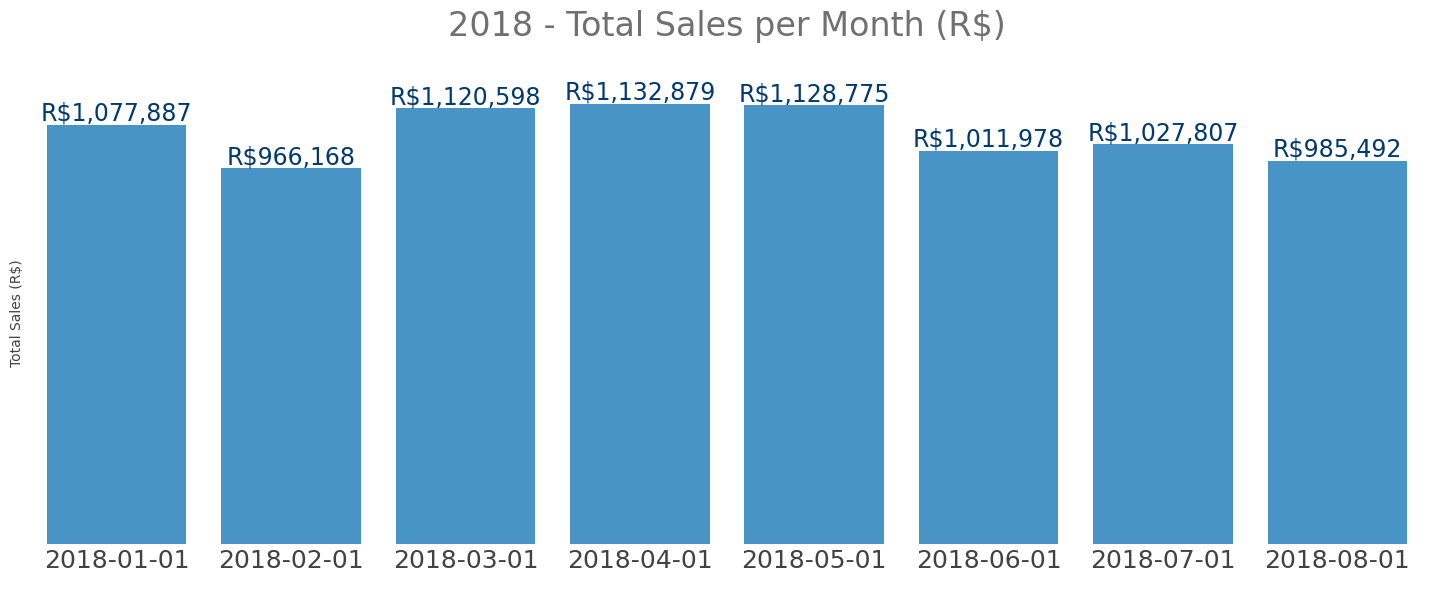

In [6]:
x = list(range(len(annual_sales['month'])))
sales = annual_sales['total_sales'].values
plt.figure(figsize=(18,6))
sns.barplot(data=annual_sales, x=annual_sales['month'].dt.date, y='total_sales', color='#3498db');

plt.box(False)
plt.title(f"2018 - Total Sales per Month (R$)\n", fontsize=24, color='#707070')
plt.tick_params(axis='both', which='both', length=0)
plt.xlabel(" ", color='#424242')
plt.ylabel("Total Sales (R$)", color='#424242')
plt.xticks(color="#424242", size=18)
plt.yticks([],[])

for sale_value in range(len(sales)):
    plt.annotate("R${:,.0f}".format(sales[sale_value]), xy=(x[sale_value],sales[sale_value]),
                 ha='center', va='bottom', size=17, color='#03396c')
plt.show()

### 1.2 Sales per Region

In [7]:
initial_date = date(2018, 1, 1)
final_date = date(2019, 1, 1)
region = 'southeast'
regional_sales_per_month_query = f'''
SELECT region, date, SUM(total_sales) FROM (
    SELECT *, 
        CASE
             WHEN customer_state IN ('AM','RR','AP','PA','TO','RO','AC') THEN 'north'
                    WHEN customer_state IN ('MA','PI','CE','RN','PE','PB','SE','AL','BA') THEN 'northeast'
                    WHEN customer_state IN ('MT','MS','GO','DF') THEN 'midwest'
                    WHEN customer_state IN ('SP','RJ','ES','MG') THEN 'southeast'
                    WHEN customer_state IN ('PR','RS','SC') THEN 'south'
                    ELSE 'unknown_region'
                END region
    FROM (
        SELECT customer_state,
               date_trunc('month', order_purchase_timestamp) AS date,
               SUM(price+freight_value) AS total_sales
        FROM orders LEFT JOIN order_items ON orders.order_id = order_items.order_id
                    LEFT JOIN customers ON orders.customer_id = customers.customer_id
        WHERE order_status='delivered' and
              order_purchase_timestamp BETWEEN date('{initial_date}') AND date('{final_date}')
        GROUP BY customer_state, date_trunc('month', order_purchase_timestamp)
        ) AS states_sales
) AS regional_sales
GROUP BY regional_sales.region, regional_sales.date
HAVING region = '{region}' 
'''

region_sales = to_pandas(bd_execute(regional_sales_per_month_query), ['region', 'month','total_sales']).sort_values('month')
region_sales

,region,month,total_sales
0,southeast,2018-01-01,711738.59
1,southeast,2018-02-01,626044.70
2,southeast,2018-03-01,720841.96
3,southeast,2018-04-01,731029.51
4,southeast,2018-05-01,763417.24
5,southeast,2018-06-01,657308.54
6,southeast,2018-07-01,630845.91
7,southeast,2018-08-01,687969.90


In [8]:
write_query(f"../sql_queries/{region}_sales_per_month_query", regional_sales_per_month_query)
print(read_query(f"../sql_queries/{region}_sales_per_month_query.sql"))


SELECT region, date, SUM(total_sales) FROM (
    SELECT *, 
        CASE
             WHEN customer_state IN ('AM','RR','AP','PA','TO','RO','AC') THEN 'north'
                    WHEN customer_state IN ('MA','PI','CE','RN','PE','PB','SE','AL','BA') THEN 'northeast'
                    WHEN customer_state IN ('MT','MS','GO','DF') THEN 'midwest'
                    WHEN customer_state IN ('SP','RJ','ES','MG') THEN 'southeast'
                    WHEN customer_state IN ('PR','RS','SC') THEN 'south'
                    ELSE 'unknown_region'
                END region
    FROM (
        SELECT customer_state,
               date_trunc('month', order_purchase_timestamp) AS date,
               SUM(price+freight_value) AS total_sales
        FROM orders LEFT JOIN order_items ON orders.order_id = order_items.order_id
                    LEFT JOIN customers ON orders.customer_id = customers.customer_id
        WHERE order_status='delivered' and
              order_purchase_timestamp BETWEEN da

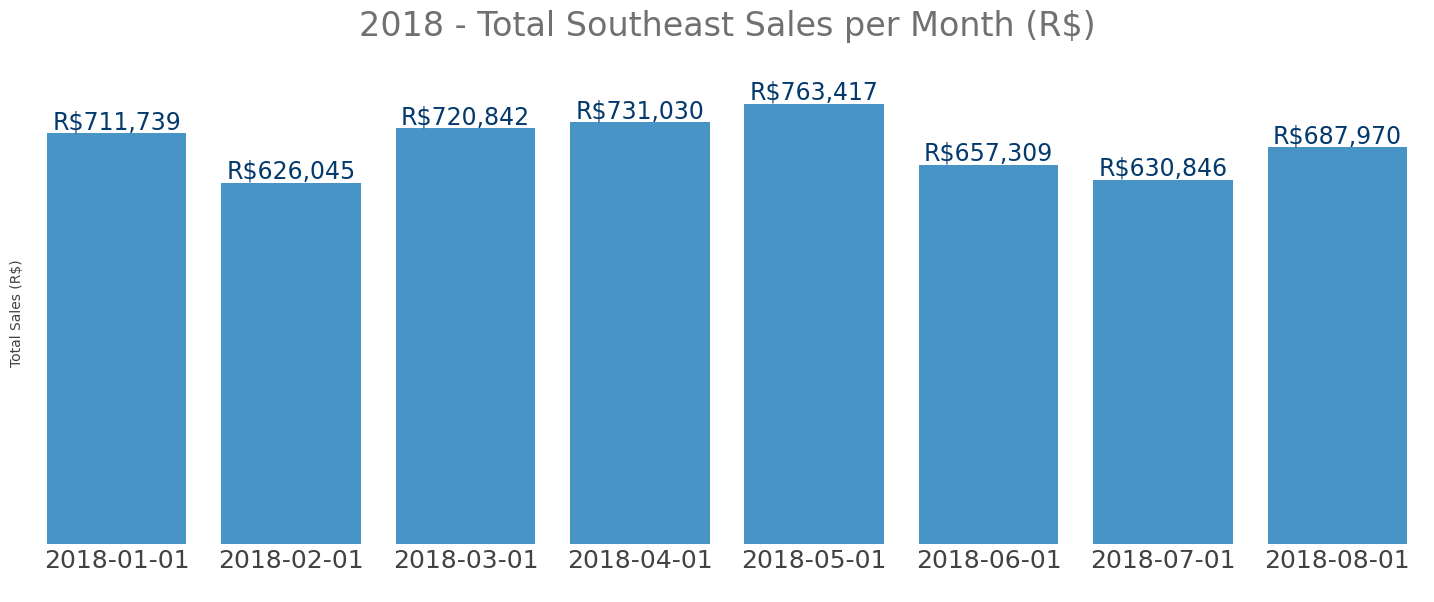

In [9]:
x = list(range(len(region_sales['month'])))
sales = region_sales['total_sales'].values
plt.figure(figsize=(18,6))
sns.barplot(data=region_sales, x=region_sales['month'].dt.date, y='total_sales', color='#3498db');

plt.box(False)
plt.title(f"2018 - Total {region.capitalize()} Sales per Month (R$)\n", fontsize=24, color='#707070')
plt.tick_params(axis='both', which='both', length=0)
plt.xlabel(" ", color='#424242')
plt.ylabel("Total Sales (R$)", color='#424242')
plt.xticks(color="#424242", size=18)
plt.yticks([],[])

for sale_value in range(len(sales)):
    plt.annotate("R${:,.0f}".format(sales[sale_value]), xy=(x[sale_value],sales[sale_value]),
                 ha='center', va='bottom', size=17, color='#03396c')
plt.show()

## 1.3 Top 5 selling categories for each Region

In [10]:
initial_date = date(2018, 1, 1)
final_date = date(2019, 1, 1)
region = 'southeast'
top_categories_sales_query = f'''
SELECT region, product_category_name, SUM(total_sales) FROM (
    SELECT *, 
        CASE
             WHEN customer_state IN ('AM','RR','AP','PA','TO','RO','AC') THEN 'north'
                    WHEN customer_state IN ('MA','PI','CE','RN','PE','PB','SE','AL','BA') THEN 'northeast'
                    WHEN customer_state IN ('MT','MS','GO','DF') THEN 'midwest'
                    WHEN customer_state IN ('SP','RJ','ES','MG') THEN 'southeast'
                    WHEN customer_state IN ('PR','RS','SC') THEN 'south'
                    ELSE 'unknown_region'
                END region
    FROM (
        SELECT customer_state,
               SUM(price+freight_value) AS total_sales,
               product_category_name AS product_category_name
        FROM orders LEFT JOIN order_items ON orders.order_id = order_items.order_id
                    LEFT JOIN customers ON orders.customer_id = customers.customer_id
                    LEFT JOIN products ON order_items.product_id = products.product_id
        WHERE order_purchase_timestamp BETWEEN date('{initial_date}') AND date('{final_date}')
        GROUP BY customer_state, product_category_name
        ) AS states_sales
) AS regional_sales
GROUP BY regional_sales.region, regional_sales.product_category_name
HAVING region = '{region}' 
'''

# ['category', f'{initial_date}_sales'] 
category_regional_sales = to_pandas(bd_execute(top_categories_sales_query),
                                    ['region', 'category', 'total_sales']).\
                                    sort_values(['total_sales'], ascending=False)
category_regional_sales.head(5)

,region,category,total_sales
11,southeast,beleza_saude,562843.75
13,southeast,cama_mesa_banho,494305.41
66,southeast,relogios_presentes,485125.95
43,southeast,informatica_acessorios,403449.95
31,southeast,esporte_lazer,402516.44


In [11]:
write_query(f"../sql_queries/{region}_top_categories_sales_query", top_categories_sales_query)
print(read_query(f"../sql_queries/{region}_top_categories_sales_query.sql"))


SELECT region, product_category_name, SUM(total_sales) FROM (
    SELECT *, 
        CASE
             WHEN customer_state IN ('AM','RR','AP','PA','TO','RO','AC') THEN 'north'
                    WHEN customer_state IN ('MA','PI','CE','RN','PE','PB','SE','AL','BA') THEN 'northeast'
                    WHEN customer_state IN ('MT','MS','GO','DF') THEN 'midwest'
                    WHEN customer_state IN ('SP','RJ','ES','MG') THEN 'southeast'
                    WHEN customer_state IN ('PR','RS','SC') THEN 'south'
                    ELSE 'unknown_region'
                END region
    FROM (
        SELECT customer_state,
               SUM(price+freight_value) AS total_sales,
               product_category_name AS product_category_name
        FROM orders LEFT JOIN order_items ON orders.order_id = order_items.order_id
                    LEFT JOIN customers ON orders.customer_id = customers.customer_id
                    LEFT JOIN products ON order_items.product_id = products.produc

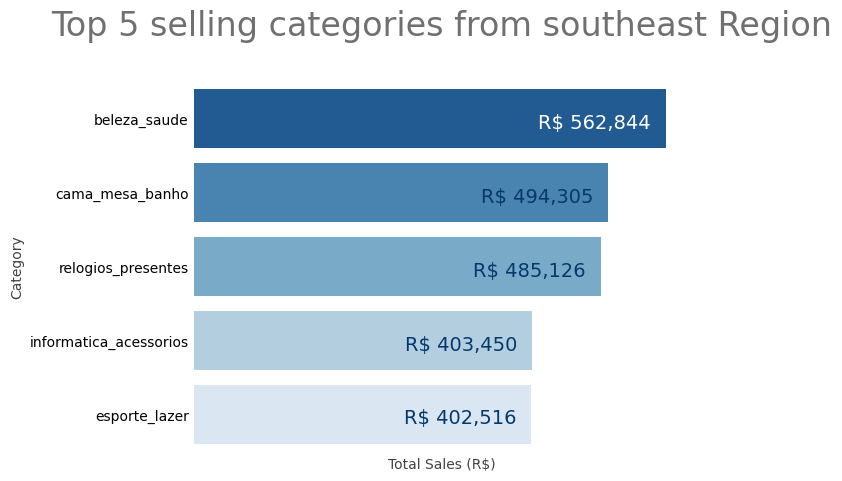

In [12]:
sns.barplot(data=category_regional_sales.head(5), x='total_sales', y='category', palette='Blues_r')

plt.box(False)
plt.title(f"Top 5 selling categories from {region} Region\n", fontsize=24, color='#707070')
plt.tick_params(axis='both', which='both', length=0)
plt.xlabel("Total Sales (R$)", color='#424242')
plt.ylabel("Category", color='#424242')
plt.xticks([],[])


x = list(range(len(category_regional_sales.head(5))))
sales = category_regional_sales.head(5)['total_sales'].values
colors = ['white','#03396c','#03396c','#03396c','#03396c']
for sale_value, color in zip(range(len(sales)), colors):
    plt.annotate("R$ {:,.0f}".format(sales[sale_value]), xy=(sales[sale_value]-85000,x[sale_value]+.18),
                 ha='center', va='bottom', size=14, color=color)
plt.show();

## 2.0 Business Areas Answers Queries

### 2.1 Is there a difference in the amount of freight charged in different regions, cities? Or can we apply the shipping subsidy rules to any location?

In [13]:
initial_date = date(2015, 1, 1)
final_date = date(2019, 1, 1)
avg_freight_per_state_query = f'''
SELECT customer_state,
       AVG(freight_value) AS avg_freight
FROM orders LEFT JOIN order_items ON orders.order_id = order_items.order_id
            LEFT JOIN customers ON orders.customer_id = customers.customer_id
WHERE order_purchase_timestamp BETWEEN date('{initial_date}') AND date('{final_date}')
GROUP BY customer_state
'''
avg_freight_per_state = to_pandas(bd_execute(avg_freight_per_state_query),
                                    ['state', 'avg_freight']).\
                                    sort_values(['avg_freight'], ascending=False)
avg_freight_per_state.head(5)

,state,avg_freight
21,RR,42.984423
14,PB,42.723804
20,RO,41.069712
0,AC,40.073370
16,PI,39.147970


In [14]:
write_query(f"../sql_queries/avg_freight_per_state_query", avg_freight_per_state_query)
print(read_query(f"../sql_queries/avg_freight_per_state_query.sql"))


SELECT customer_state,
       AVG(freight_value) AS avg_freight
FROM orders LEFT JOIN order_items ON orders.order_id = order_items.order_id
            LEFT JOIN customers ON orders.customer_id = customers.customer_id
WHERE order_purchase_timestamp BETWEEN date('2015-01-01') AND date('2019-01-01')
GROUP BY customer_state



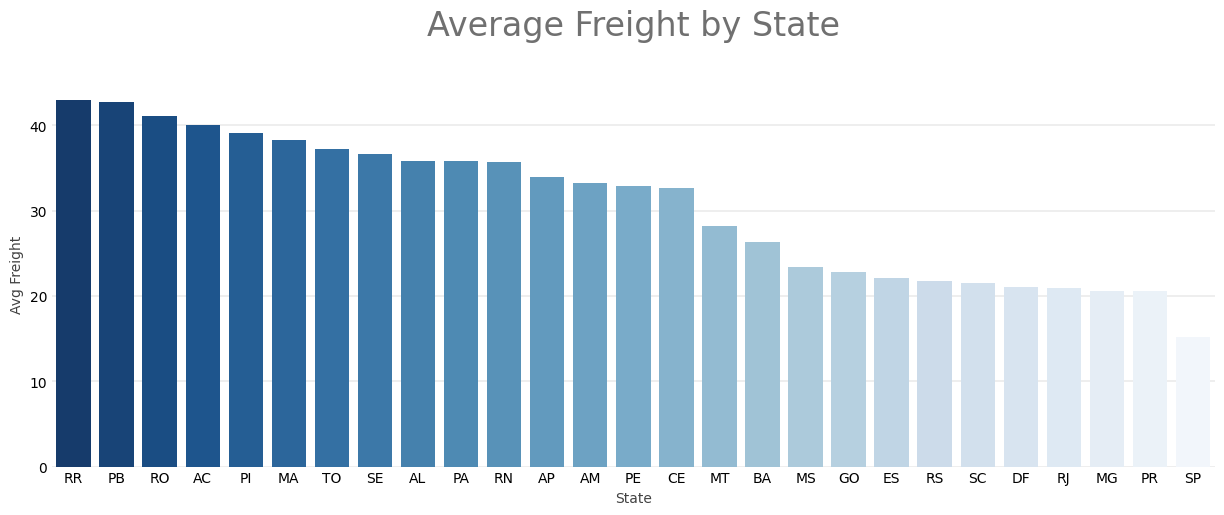

In [15]:
fig(15,5);
sns.barplot(data=avg_freight_per_state, x='state', y='avg_freight', palette="Blues_r", zorder=2)
plt.box(False)
plt.grid(axis='y', zorder=0, linewidth=.3)
plt.title(f"Average Freight by State\n", fontsize=24, color='#707070')
plt.tick_params(axis='both', which='both', length=0)
plt.xlabel("State", color='#424242')
plt.ylabel("Avg Freight", color='#424242')
plt.show()

In [16]:
initial_date = date(2015, 1, 1)
final_date = date(2019, 1, 1)
region = 'southeast'
avg_freight_per_region_query = f'''
SELECT region, AVG(avg_freight) FROM (
    SELECT *, 
        CASE
             WHEN customer_state IN ('AM','RR','AP','PA','TO','RO','AC') THEN 'north'
                    WHEN customer_state IN ('MA','PI','CE','RN','PE','PB','SE','AL','BA') THEN 'northeast'
                    WHEN customer_state IN ('MT','MS','GO','DF') THEN 'midwest'
                    WHEN customer_state IN ('SP','RJ','ES','MG') THEN 'southeast'
                    WHEN customer_state IN ('PR','RS','SC') THEN 'south'
                    ELSE 'unknown_region'
                END region
    FROM (
        SELECT customer_state,
               AVG(freight_value) AS avg_freight
        FROM orders LEFT JOIN order_items ON orders.order_id = order_items.order_id
                    LEFT JOIN customers ON orders.customer_id = customers.customer_id
        WHERE order_purchase_timestamp BETWEEN date('{initial_date}') AND date('{final_date}')
        GROUP BY customer_state
        ) AS states_sales
) AS regional_sales
GROUP BY regional_sales.region
'''

avg_freight_per_region = to_pandas(bd_execute(avg_freight_per_region_query),
                                    ['region', 'avg_freight']).\
                                    sort_values(['avg_freight'], ascending=False)
avg_freight_per_region.head(5)

,region,avg_freight
1,north,37.774041
2,northeast,35.586000
0,midwest,23.837335
3,south,21.245942
4,southeast,19.699286


In [17]:
write_query(f"../sql_queries/avg_freight_per_region_query", avg_freight_per_region_query)
print(read_query(f"../sql_queries/avg_freight_per_region_query.sql"))


SELECT region, AVG(avg_freight) FROM (
    SELECT *, 
        CASE
             WHEN customer_state IN ('AM','RR','AP','PA','TO','RO','AC') THEN 'north'
                    WHEN customer_state IN ('MA','PI','CE','RN','PE','PB','SE','AL','BA') THEN 'northeast'
                    WHEN customer_state IN ('MT','MS','GO','DF') THEN 'midwest'
                    WHEN customer_state IN ('SP','RJ','ES','MG') THEN 'southeast'
                    WHEN customer_state IN ('PR','RS','SC') THEN 'south'
                    ELSE 'unknown_region'
                END region
    FROM (
        SELECT customer_state,
               AVG(freight_value) AS avg_freight
        FROM orders LEFT JOIN order_items ON orders.order_id = order_items.order_id
                    LEFT JOIN customers ON orders.customer_id = customers.customer_id
        WHERE order_purchase_timestamp BETWEEN date('2015-01-01') AND date('2019-01-01')
        GROUP BY customer_state
        ) AS states_sales
) AS regional_sales
GROUP B

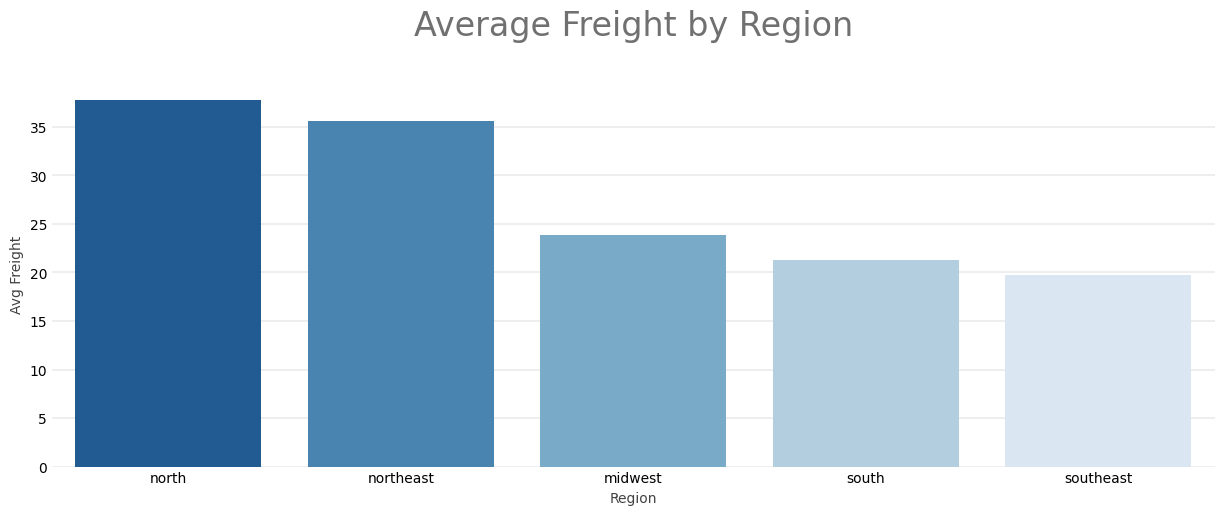

In [18]:
fig(15,5)
sns.barplot(data=avg_freight_per_region, x='region', y='avg_freight', palette="Blues_r", zorder=2)
plt.box(False)
plt.grid(axis='y', zorder=0, linewidth=.3)
plt.title(f"Average Freight by Region\n", fontsize=24, color='#707070')
plt.tick_params(axis='both', which='both', length=0)
plt.xlabel("Region", color='#424242')
plt.ylabel("Avg Freight", color='#424242')
plt.show()

### 2.2 Is our product catalog comprehensive? Or does it focus on specific categories?

In [19]:
initial_date = date(2018, 1, 1)
final_date = date(2019, 1, 1)
orders_by_product_category_query = f'''
    SELECT product_category_name AS category,
           COUNT(order_items.order_id) AS number_of_orders           
    FROM products RIGHT JOIN order_items ON order_items.product_id = products.product_id
                  LEFT JOIN orders ON orders.order_id = order_items.order_id
    WHERE order_approved_at BETWEEN DATE('{initial_date}') AND DATE('{final_date}')
    GROUP BY product_category_name
'''

orders_by_product_category = to_pandas(bd_execute(orders_by_product_category_query),
                                    ['category', 'number_of_orders'])#.\
                                    #sort_values(['avg_freight'], ascending=False)
orders_by_product_category.head(5)

,category,number_of_orders
0,agro_industria_e_comercio,151
1,alimentos,382
2,alimentos_bebidas,147
3,artes,168
4,artes_e_artesanato,22


In [20]:
write_query(f"../sql_queries/orders_by_product_category_query", orders_by_product_category_query)
print(read_query(f"../sql_queries/orders_by_product_category_query.sql"))


    SELECT product_category_name AS category,
           COUNT(order_items.order_id) AS number_of_orders           
    FROM products RIGHT JOIN order_items ON order_items.product_id = products.product_id
                  LEFT JOIN orders ON orders.order_id = order_items.order_id
    WHERE order_approved_at BETWEEN DATE('2018-01-01') AND DATE('2019-01-01')
    GROUP BY product_category_name



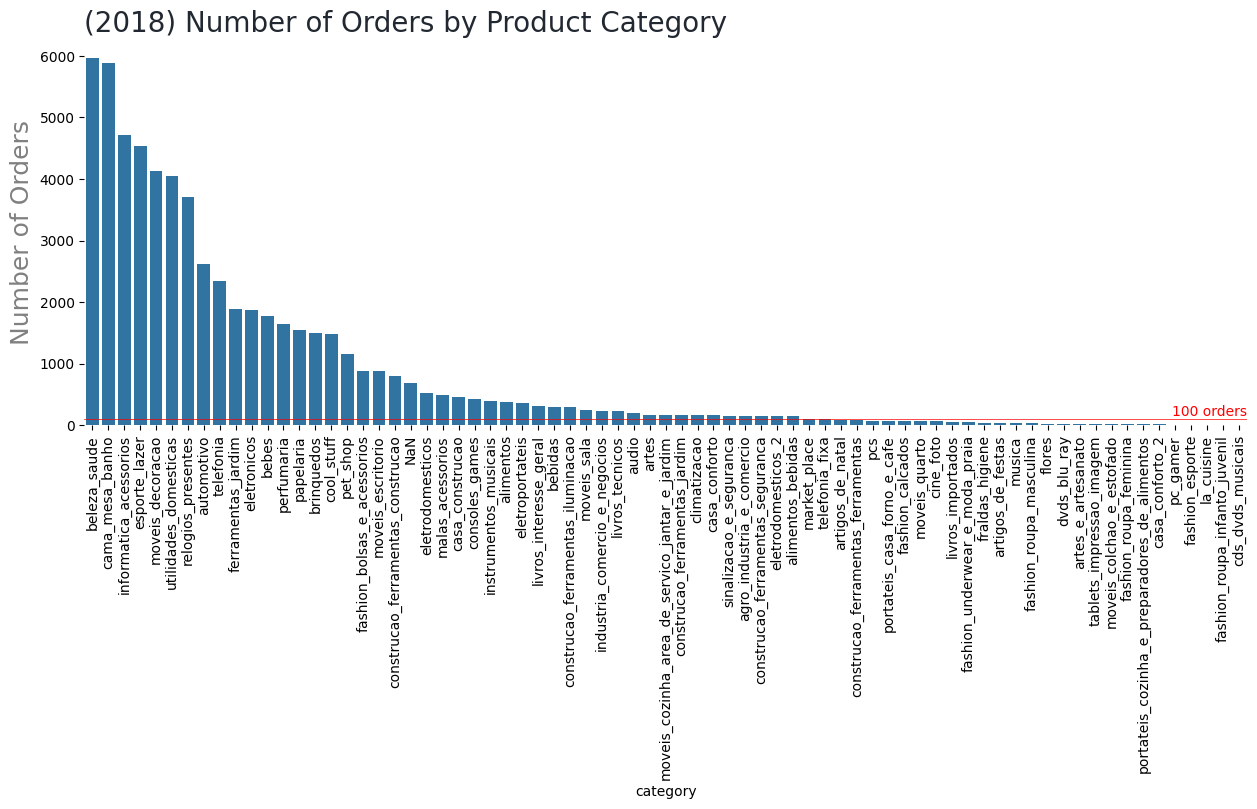

In [21]:
fig(); plt.box(False)
sns.barplot(data=orders_by_product_category.sort_values("number_of_orders", ascending=False),
            x='category', y='number_of_orders', color='tab:blue')
plt.title("(2018) Number of Orders by Product Category", size=20, loc='left', color='#222831')
plt.ylabel("Number of Orders", size=18, color='grey')
plt.axhline(100, c='r', label='100 orders', linewidth=0.5); plt.text(67.8, 155, "100 orders", color='r')
plt.xticks(rotation=90)
plt.show()

###  2.3 Can we give the same benefits to all shopkeepers (sellers)? Or is there one that deserves to be highlighted?

In [83]:
initial_date = date(2018, 1, 1)
final_date = date(2018, 10, 1)
sellers_rank_abt_query = f'''
    SELECT seller_id,
           total_revenue/months_since_first_sale AS revenue_per_month,
           orders_quantity/months_since_first_sale AS orders_per_month,
           PERCENT_RANK() OVER (ORDER BY (total_revenue/months_since_first_sale)) AS percent_revenue,
           PERCENT_RANK() OVER (ORDER BY (orders_quantity/months_since_first_sale)) AS percent_orders
    FROM (
        SELECT seller_id,
               SUM(price) AS total_revenue,
               COUNT(orders.order_id) AS orders_quantity,
               DATE_PART('month', AGE(DATE('{final_date}'), MIN(order_approved_at))) AS months_since_first_sale
        FROM orders LEFT JOIN order_items ON orders.order_id = order_items.order_id
        WHERE order_approved_at BETWEEN DATE('{initial_date}') AND DATE('{final_date}') AND
              seller_id IS NOT NULL
        GROUP BY seller_id
    ) AS percent_rank_segment
'''
columns = ['seller_id', 'revenue_per_month', 'orders_per_month', 'value_rank', 'frequency_rank']
sellers_rank_abt = to_pandas(bd_execute(sellers_rank_abt_query), columns)
sellers_rank_abt.head(5)

,seller_id,revenue_per_month,orders_per_month,value_rank,frequency_rank
0,3d62f86afa7c73be2628a3be1423f5a0,0.750000,0.125000,0.000000,0.000000
1,344223b2a90784f64136a8a5da012e7f,1.362500,0.125000,0.000420,0.000000
2,4965a7002cca77301c82d3f91b82e1a9,1.698000,0.200000,0.000840,0.047859
3,c161d1327ebc3a156c09582ab2f59f6c,2.428571,0.142857,0.001259,0.017212
4,2c54051840f19eca309a5423cf22df36,2.470000,0.200000,0.001679,0.047859


In [84]:
write_query(f"../sql_queries/sellers_rank_abt_query", sellers_rank_abt_query)
print(read_query(f"../sql_queries/sellers_rank_abt_query.sql"))


    SELECT seller_id,
           total_revenue/months_since_first_sale AS revenue_per_month,
           orders_quantity/months_since_first_sale AS orders_per_month,
           PERCENT_RANK() OVER (ORDER BY (total_revenue/months_since_first_sale)) AS percent_revenue,
           PERCENT_RANK() OVER (ORDER BY (orders_quantity/months_since_first_sale)) AS percent_orders
    FROM (
        SELECT seller_id,
               SUM(price) AS total_revenue,
               COUNT(orders.order_id) AS orders_quantity,
               DATE_PART('month', AGE(DATE('2018-10-01'), MIN(order_approved_at))) AS months_since_first_sale
        FROM orders LEFT JOIN order_items ON orders.order_id = order_items.order_id
        WHERE order_approved_at BETWEEN DATE('2018-01-01') AND DATE('2018-10-01') AND
              seller_id IS NOT NULL
        GROUP BY seller_id
    ) AS percent_rank_segment



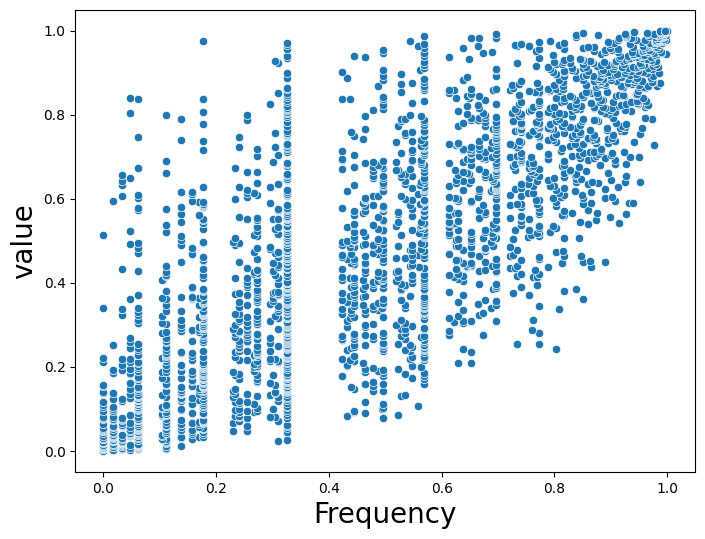

In [78]:
fig(8,6)
plt.xlabel('Frequency', size=20)
plt.ylabel('value', size=20)
sns.scatterplot(data=sellers_rank_abt, x='frequency_rank', y='value_rank')
plt.show()

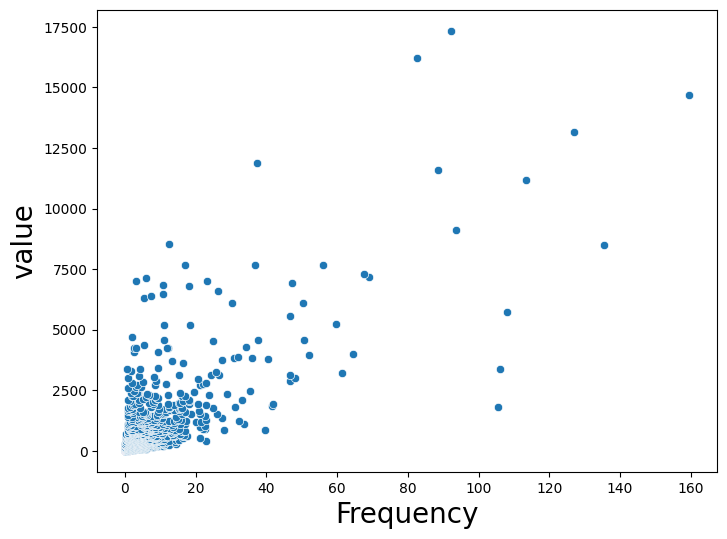

In [85]:
fig(8,6)
plt.xlabel('Frequency', size=20)
plt.ylabel('value', size=20)
sns.scatterplot(data=sellers_rank_abt, x='orders_per_month', y='revenue_per_month')
plt.show()